# Face Recognition

## Jesmine Tey Khai Jing - InsightFace

### Data Preparation

In [2]:
# Import necessary libraries
import os
import cv2 as cv
import pickle
import sqlite3
import csv
from insightface.app import FaceAnalysis

# Initialize model
detector = FaceAnalysis(providers=['CUDAExecutionProvider'])
detector.prepare(ctx_id=0, det_size=(640,640))

# Initializer
OUTPUT_FILE = "database/face_embeddings.pkl"
DIRECTORY = "photos"
INITIAL_DATASET = "dataset/dataset.csv"
INFO_DATABASE = "database/information.db"

# Process image function
def process_img(folder_path: str, output_file=OUTPUT_FILE):
    embeddings_data = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is None:
                print(f"Warning -> Could not read {filename}")
                continue

            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            faces = detector.get(img_rgb)

            if not faces:
                print(f"Warning -> No face found in {filename}")
                continue

            # Take the first face embeddings
            face = faces[0]
            embedding = face.normed_embedding
            user_id = os.path.splitext(filename)[0]

            embeddings_data.append({
                'id': user_id,
                'image_name': filename,
                'embedding': embedding
            })

    # Save the embedding to files
    with open(output_file, "wb") as file:
        pickle.dump(embeddings_data, file, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Save embeddings to {output_file} successfully")

process_img(DIRECTORY)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Save embeddings to database/face_embeddings.pkl successfully


### Face Recognition

In [4]:
# Import necessary libraries
import cv2 as cv
import pickle
import time
import numpy as np
from insightface.app import FaceAnalysis
from huggingface_hub import hf_hub_download

# Initializer
detector = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider'])
detector.prepare(ctx_id=0, det_size=(640, 640), det_thresh=0.5)

# Load saved embeddings
file_path = "database/face_embeddings.pkl"
with open(file_path, "rb") as f:
    embeddings_data = pickle.load(f)

# Smoother Class
class RecognitionSmoother:
    def __init__(self, window_size=5):
        self.window_size = window_size
        self.history = []
    
    def add_recognition(self, person_id, score):
        self.history.append((person_id, score))
        if len(self.history) > self.window_size:
            self.history.pop(0)
    
    def get_smoothed_result(self):
        if not self.history:
            return None, 0

        weights = np.linspace(0.5, 1.5, len(self.history))
        scores = {}
        
        for (pid, score), weight in zip(self.history, weights):
            if pid not in scores:
                scores[pid] = []
            scores[pid].append(score * weight)
        
        avg_scores = {pid: np.mean(vals) for pid, vals in scores.items()}
        best_pid = max(avg_scores.items(), key=lambda x: x[1])[0]
        best_score = avg_scores[best_pid]
        
        return best_pid, best_score
    
# Initialize smoother
smoother = RecognitionSmoother(window_size=5)

# Initialize camera
video = cv.VideoCapture(0)

# Get embeddings
def get_face_embedding_from_obj(face_obj):
    emb = face_obj.embedding
    if emb is None:
        return None
    return emb / np.linalg.norm(emb)

# Use Cosine similarity
def recognize_face(embedding, dataset, threshold=0.5):
    if embedding is None:
        return None, None, -1

    best_score = -1
    best_id = None
    best_name = None

    for entry in dataset:
        db_embedding = entry["embedding"]
        db_embedding = db_embedding / np.linalg.norm(db_embedding)

        cos_sim = np.dot(embedding, db_embedding)
        if cos_sim > best_score:
            best_score = cos_sim
            best_id = entry["id"]
            best_name = entry["image_name"]

    if best_score < threshold:
        return None, None, best_score

    return best_id, best_name, best_score

# Draw rectangle on the face
def draw_result(image, name, score):
    faces = detector.get(image)
    if not faces:
        return image

    h, w, _ = image.shape
    img_center = np.array([w // 2, h // 2])
    closest_face, min_dist = None, float("inf")

    for face in faces:
        bbox = face.bbox.astype(int)
        face_center = np.array([(bbox[0] + bbox[2]) // 2, (bbox[1] + bbox[3]) // 2])
        dist = np.linalg.norm(face_center - img_center)
        if dist < min_dist:
            min_dist = dist
            closest_face = face

    if closest_face is None:
        return image

    bbox = closest_face.bbox.astype(int)
    cv.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    label = f"{name} ({score:.2f})" if name else "Unknown"
    cv.putText(image, label, (bbox[0], bbox[1] - 10),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return image

def real_time_pipeline():
    current_person = None
    start_time = None

    while True:
        ret, frame = video.read()
        if not ret:
            break

        frame = cv.flip(frame, 1)
        rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        faces = detector.get(rgb_frame)

        if faces:
            # pick best face (highest det_score)
            faces.sort(key=lambda f: f.det_score, reverse=True)
            best_face = faces[0]

            # face quality filtering
            if best_face.det_score < 0.6:
                continue
            if (best_face.bbox[2] - best_face.bbox[0]) < 80:
                continue

            # get embedding
            embedding = get_face_embedding_from_obj(best_face)

            # recognize
            person_id, name, score = recognize_face(embedding, embeddings_data)

            # smooth results
            smoother.add_recognition(person_id, score)
            smoothed_id, smoothed_score = smoother.get_smoothed_result()

            # draw
            frame = draw_result(frame, name, smoothed_score)

            # stable detection for 5s
            if smoothed_id == current_person:
                if start_time and (time.time() - start_time >= 5):
                    print(f"Detected id: {smoothed_id}, Score: {smoothed_score}")
                    start_time = None
            else:
                current_person = smoothed_id
                start_time = time.time()

        # draw middle guide box
        h, w, _ = frame.shape
        rect_w, rect_h = 200, 200
        center_x, center_y = w // 2, h // 2
        top_left = (center_x - rect_w // 2, center_y - rect_h // 2)
        bottom_right = (center_x + rect_w // 2, center_y + rect_h // 2)
        cv.rectangle(frame, top_left, bottom_right, (255, 0, 0), 2)

        cv.imshow("Face Recognition", frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()
    cv.destroyAllWindows()

real_time_pipeline()

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

## Ethel Ng Yi Yan - MTCNN with FaceNet

### Data Preparation

In [ ]:
import cv2
from mtcnn import MTCNN
from keras_facenet import FaceNet

# Initialize detector and embedder
detector = MTCNN()
embedder = FaceNet()

# Folder containing known faces
photo_dir = "photos"
dataset_dir = "database"
os.makedirs(dataset_dir, exist_ok=True)
pkl_path = os.path.join(dataset_dir, "facenet_embeddings.pkl")

def l2_normalize(x):
    return x / np.linalg.norm(x)

# Get embedding from image path
def get_face_embedding(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARNING] Failed to load image: {img_path}")
        return None
    
    results = detector.detect_faces(img)
    if len(results) == 0:
        print(f"[INFO] No face detected in: {img_path}")
        return None
    
    face = results[0]
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    
    face_img = img[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, (160, 160))
    
    embedding = embedder.embeddings([face_img])[0]
    embedding = l2_normalize(embedding)
    return embedding

# Build the face database from photo directory
def build_face_database(folder):
    database = {}
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, file)
            name = os.path.splitext(file)[0]
            print(f"Processing: {file}")
            embedding = get_face_embedding(path)
            if embedding is not None:
                database[name] = embedding
            else:
                print(f"[SKIPPED] {file}")
    return database

# Load existing database or create a new one
if os.path.exists(pkl_path):
    print(f"Loading FaceNet embeddings from {pkl_path}")
    with open(pkl_path, "rb") as f:
        face_database = pickle.load(f)
else:
    print("Building FaceNet embeddings database...")
    face_database = build_face_database(photo_dir)
    with open(pkl_path, "wb") as f:
        pickle.dump(face_database, f)
    print(f"Database saved to {pkl_path}")

print(f"Loaded {len(face_database)} valid faces from database.")



📂 Loading FaceNet embeddings from database\facenet_embeddings.pkl
✅ Loaded 22 valid faces from database.


### Face Recognition

In [6]:
import cv2
from sklearn.metrics.pairwise import cosine_similarity

# Get top N matches with cosine similarity
def get_top_matches(face_img, database, top_n=3):
    face_img = cv2.resize(face_img, (160, 160))
    embedding = embedder.embeddings([face_img])[0]
    embedding = l2_normalize(embedding)

    similarities = []
    for name, db_emb in database.items():
        sim_score = cosine_similarity([embedding], [db_emb])[0][0]  # Higher is better
        similarities.append((name, sim_score))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

def real_time():
    # Start webcam recognition with stillness detection
    video = cv2.VideoCapture(0)
    print("📷 Press 'q' to quit...")

    # Parameters for stillness detection
    still_threshold = 10  # max movement in pixels to consider still
    still_duration = 2    # seconds to hold still before capture

    last_face_pos = None
    still_start_time = None
    captured = False
    top_matches = []

    while True:
        ret, frame = video.read()
        if not ret:
            break

        results = detector.detect_faces(frame)

        if len(results) == 0:
            last_face_pos = None
            still_start_time = None
            captured = False
            top_matches = []
        else:
            largest_face = max(results, key=lambda f: f['box'][2] * f['box'][3])
            x, y, w, h = largest_face['box']
            x, y = max(0, x), max(0, y)

            if last_face_pos is not None:
                lx, ly, lw, lh = last_face_pos
                movement = abs(x - lx) + abs(y - ly) + abs(w - lw) + abs(h - lh)
            else:
                movement = None

            if movement is not None and movement < still_threshold:
                if still_start_time is None:
                    still_start_time = time.time()
                else:
                    elapsed = time.time() - still_start_time
                    remaining = int(still_duration - elapsed) + 1

                    countdown_label = f"Hold still... {remaining}s"
                    (label_width, label_height), baseline = cv2.getTextSize(countdown_label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                    cv2.rectangle(frame, (x, y - label_height - baseline - 10), (x + label_width, y), (0, 255, 255), cv2.FILLED)
                    cv2.putText(frame, countdown_label, (x, y - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

                    if elapsed >= still_duration and not captured:
                        margin = 10
                        x1 = max(0, x - margin)
                        y1 = max(0, y - margin)
                        x2 = min(frame.shape[1], x + w + margin)
                        y2 = min(frame.shape[0], y + h + margin)
                        face_img = frame[y1:y2, x1:x2]

                        top_matches = get_top_matches(face_img, face_database)

                        print(f"\nCaptured face after being still for {still_duration} seconds:")
                        for match_name, sim in top_matches:
                            print(f"  {match_name}: {sim * 100:.2f}% similarity")

                        captured = True
            else:
                still_start_time = None
                captured = False
                top_matches = []

            last_face_pos = (x, y, w, h)

            if captured and top_matches:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                best_name, best_sim = top_matches[0]
                label = f"{best_name} ({best_sim*100:.1f}%)"
                (label_width, label_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                cv2.rectangle(frame, (x, y - label_height - baseline - 5), (x + label_width, y), (0, 255, 0), cv2.FILLED)
                cv2.putText(frame, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            else:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)

        cv2.imshow('Face Recognition with MTCNN + FaceNet', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()

real_time()

📷 Press 'q' to quit...


# Model Evaluation for Face Recognition

In [1]:
# Import necessary libraries
import os
import cv2
import pickle
import numpy as np
import pandas as pd
from insightface.app import FaceAnalysis
from mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.metrics import accuracy_score

name_to_id = {
    "Ethel": "24WMR08861",
    "Jesmine": "24WMR08866",
    "Khaili": "24WMR08863",
    "Kit": "24WMR08870"
}
id_to_name = {v: k for k, v in name_to_id.items()}

with open("database/face_embeddings.pkl", "rb") as f:
    embeddings_insight = pickle.load(f)

with open("database/facenet_embeddings.pkl", "rb") as f:
    embeddings_facenet = pickle.load(f)

insight_detector = FaceAnalysis(name="buffalo_m", providers=['CUDAExecutionProvider'])
insight_detector.prepare(ctx_id=0, det_size=(640, 640))

mtcnn_detector = MTCNN()
facenet = FaceNet()

def get_face_embedding_from_obj(face_obj):
    emb = face_obj.embedding
    if emb is None:
        return None
    return emb / np.linalg.norm(emb)

def recognize_face(embedding, dataset, threshold=0.5):
    if embedding is None:
        return None, None, -1

    best_score = -1
    best_id, best_name = None, None

    for entry in dataset:
        db_embedding = entry["embedding"]
        db_embedding = db_embedding / np.linalg.norm(db_embedding)

        cos_sim = np.dot(embedding, db_embedding)
        if cos_sim > best_score:
            best_score = cos_sim
            best_id = entry["id"]
            best_name = entry["image_name"]

    if best_score < threshold:
        return None, None, best_score

    return best_id, best_name, best_score

def get_top_matches(face_img, database, top_n=1, threshold=0.5):
    face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    embeddings = facenet.embeddings([face_img_rgb])
    if embeddings is None or len(embeddings) == 0:
        return []

    query_emb = embeddings[0] / np.linalg.norm(embeddings[0])

    scores = []
    for entry in database:
        db_embedding = entry["embedding"]
        db_embedding = db_embedding / np.linalg.norm(db_embedding)
        cos_sim = np.dot(query_emb, db_embedding)
        scores.append((entry["id"], cos_sim))

    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return [s for s in scores if s[1] >= threshold][:top_n]

def evaluate_model(test_dir, method="insightface", threshold=0.5):
    y_true, y_pred = [], []

    if method == "insightface":
        database = embeddings_insight
    elif method == "mtcnn":
        database = embeddings_facenet
    else:
        raise ValueError("Invalid method. Use 'insightface' or 'mtcnn'.")

    for person_name in os.listdir(test_dir):
        person_path = os.path.join(test_dir, person_name)
        if not os.path.isdir(person_path):
            continue

        for img_file in os.listdir(person_path):
            if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            pred_name = "Unknown"

            # ---------------- INSIGHTFACE ----------------
            if method == "insightface":
                faces = insight_detector.get(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if not faces:
                    continue
                best_face = max(faces, key=lambda f: f.det_score)
                emb = get_face_embedding_from_obj(best_face)
                pid, name, score = recognize_face(emb, database, threshold)

                pred_name = id_to_name.get(pid, "Unknown") if pid else "Unknown"

            # ---------------- MTCNN + FACENET ----------------
            elif method == "mtcnn":
                results = mtcnn_detector.detect_faces(img)
                if len(results) == 0:
                    print(f"[INFO] No face detected in {img_file}")
                    y_true.append(person_name)
                    y_pred.append("Unknown")
                    continue

                # pick largest face
                largest = max(results, key=lambda r: r['box'][2] * r['box'][3])
                x, y, w, h = largest['box']
                x, y = max(0, x), max(0, y)
                x2, y2 = min(x+w, img.shape[1]), min(y+h, img.shape[0])
                face_img = img[y:y2, x:x2]

                try:
                    # preprocess for FaceNet
                    face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                    face_rgb = cv2.resize(face_rgb, (160, 160))

                    embeddings = facenet.embeddings([face_rgb])
                    if embeddings is None or len(embeddings) == 0:
                        print(f"[WARNING] No embedding for {img_file}")
                        y_true.append(person_name)
                        y_pred.append("Unknown")
                        continue

                    query_emb = embeddings[0] / np.linalg.norm(embeddings[0])

                    scores = []
                    # handle both dict and list of dicts
                    if isinstance(database, dict):
                        for pid, db_emb in database.items():
                            db_emb = db_emb / np.linalg.norm(db_emb)
                            cos_sim = np.dot(query_emb, db_emb)
                            scores.append((pid, cos_sim))
                    elif isinstance(database, list):
                        for entry in database:
                            db_emb = entry["embedding"] / np.linalg.norm(entry["embedding"])
                            cos_sim = np.dot(query_emb, db_emb)
                            scores.append((entry["id"], cos_sim))

                    scores.sort(key=lambda x: x[1], reverse=True)

                    if scores and scores[0][1] >= threshold:
                        matched_id = scores[0][0]
                        pred_name = id_to_name.get(matched_id, matched_id)
                    else:
                        pred_name = "Unknown"

                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    y_true.append(person_name)
                    y_pred.append("Unknown")
                    continue

            gt_name = person_name
            y_true.append(gt_name)
            y_pred.append(pred_name)

            print(f"[{method}] GT: {gt_name}, Pred: {pred_name}, File: {img_file}")

    acc = accuracy_score(y_true, y_pred)
    return acc, y_true, y_pred

# ---------------- RUN TEST ----------------
test_dir = "test_photos"

acc_insight, y_true_insight, y_pred_insight = evaluate_model(test_dir, method="insightface", threshold=0.5)
acc_mtcnn, y_true_mtcnn, y_pred_mtcnn = evaluate_model(test_dir, method="mtcnn", threshold=0.5)

persons = sorted(set(y_true_insight))
data = []
for person in persons:
    mask_insight = [gt == person for gt in y_true_insight]
    acc_person_insight = accuracy_score(
        np.array(y_true_insight)[mask_insight],
        np.array(y_pred_insight)[mask_insight]
    )

    mask_mtcnn = [gt == person for gt in y_true_mtcnn]
    acc_person_mtcnn = accuracy_score(
        np.array(y_true_mtcnn)[mask_mtcnn],
        np.array(y_pred_mtcnn)[mask_mtcnn]
    )

    data.append([person, acc_person_insight, acc_person_mtcnn])

data.append(["Overall", acc_insight, acc_mtcnn])

df = pd.DataFrame(data, columns=["Person", "InsightFace Accuracy", "MTCNN+FaceNet Accuracy"])
print("\nAccuracy Comparison Table:")
print(df.to_string(index=False))


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_m\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_m\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_m\det_2.5g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_m\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_m\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 12

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[insightface] GT: Ethel, Pred: Ethel, File: ethel_1.jpg
[insightface] GT: Ethel, Pred: Unknown, File: ethel_10.jpg
[insightface] GT: Ethel, Pred: Ethel, File: ethel_2.jpg
[insightface] GT: Ethel, Pred: Ethel, File: ethel_3.JPG
[insightface] GT: Ethel, Pred: Unknown, File: ethel_4.jpg
[insightface] GT: Ethel, Pred: Unknown, File: ethel_5.jpg
[insightface] GT: Ethel, Pred: Ethel, File: ethel_6.JPG
[insightface] GT: Ethel, Pred: Ethel, File: ethel_7.JPG
[insightface] GT: Ethel, Pred: Ethel, File: ethel_8.JPG
[insightface] GT: Ethel, Pred: Ethel, File: ethel_9.JPG
[insightface] GT: Jesmine, Pred: Jesmine, File: jesmine_1.jpg
[insightface] GT: Jesmine, Pred: Jesmine, File: jesmine_10.jpg
[insightface] GT: Jesmine, Pred: Jesmine, File: jesmine_2.jpg
[insightface] GT: Jesmine, Pred: Jesmine, File: jesmine_3.jpg
[insightface] GT: Jesmine, Pred: Jesmine, File: jesmine_4.jpg
[insightface] GT: Jesmine, Pred: Jesmine, File: jesmine_5.jpg
[insightface] GT: Jesmine, Pred: Jesmine, File: jesmine_6.jp


Classification Report - InsightFace
              precision    recall  f1-score   support

       Ethel       1.00      0.70      0.82        10
     Jesmine       1.00      1.00      1.00        10
      Khaili       1.00      1.00      1.00        10
         Kit       1.00      1.00      1.00        10
     Unknown       0.00      0.00      0.00         0

    accuracy                           0.93        40
   macro avg       0.80      0.74      0.76        40
weighted avg       1.00      0.93      0.96        40


Classification Report - MTCNN+FaceNet
              precision    recall  f1-score   support

  24WMR08834       0.00      0.00      0.00         0
       Ethel       1.00      0.90      0.95        10
     Jesmine       1.00      1.00      1.00        10
      Khaili       1.00      1.00      1.00        10
         Kit       1.00      1.00      1.00        10

    accuracy                           0.97        40
   macro avg       0.80      0.78      0.79        40
w

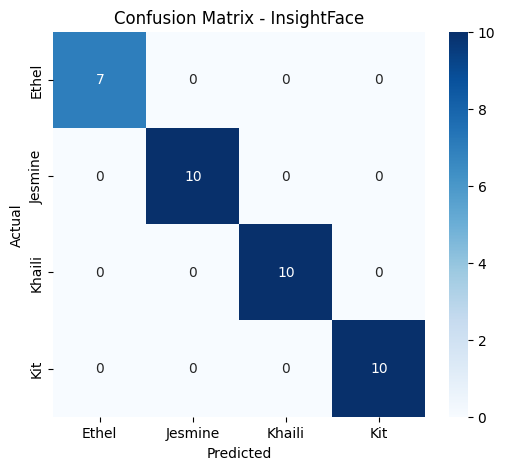

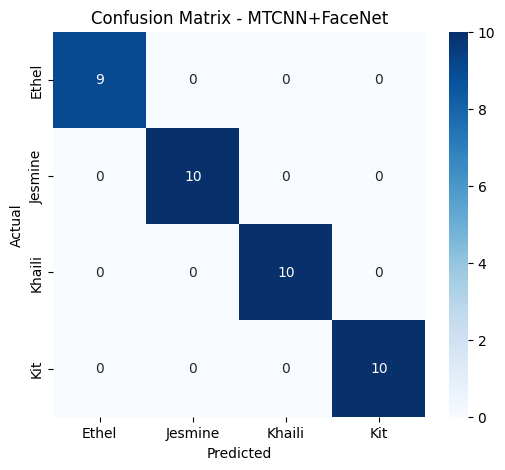

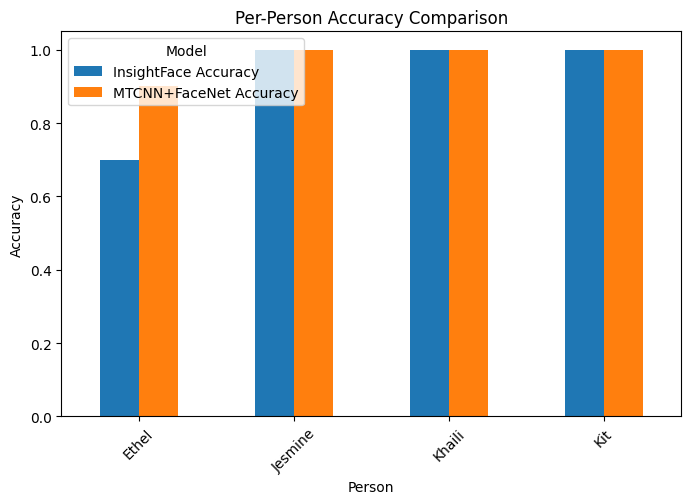

C:\Users\User\AppData\Local\Temp\ipykernel_31908\2780162012.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=overall, palette="viridis")


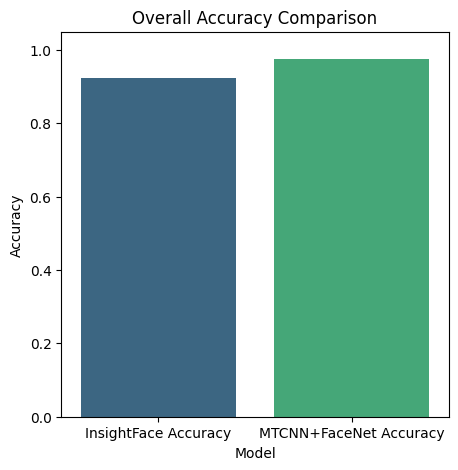

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ---------- Confusion Matrix ----------
def plot_confusion(y_true, y_pred, model_name):
    labels = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ---------- Classification Report ----------
def print_report(y_true, y_pred, model_name):
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_true, y_pred, zero_division=0))

# ---------- Accuracy Bar Chart ----------
def plot_accuracy_comparison(df):
    df_plot = df[df["Person"] != "Overall"]
    df_plot.set_index("Person", inplace=True)
    df_plot.plot(kind="bar", figsize=(8, 5))
    plt.title("Per-Person Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.show()

# ---------- Overall Accuracy ----------
def plot_overall_accuracy(df):
    overall = df[df["Person"] == "Overall"].melt(
        id_vars="Person", var_name="Model", value_name="Accuracy"
    )
    plt.figure(figsize=(5, 5))
    sns.barplot(x="Model", y="Accuracy", data=overall, palette="viridis")
    plt.title("Overall Accuracy Comparison")
    plt.ylim(0, 1.05)
    plt.show()


# ================== RUN VISUALIZATIONS ==================
# Reports
print_report(y_true_insight, y_pred_insight, "InsightFace")
print_report(y_true_mtcnn, y_pred_mtcnn, "MTCNN+FaceNet")

# Confusion Matrices
plot_confusion(y_true_insight, y_pred_insight, "InsightFace")
plot_confusion(y_true_mtcnn, y_pred_mtcnn, "MTCNN+FaceNet")

# Accuracy Comparisons
plot_accuracy_comparison(df)
plot_overall_accuracy(df)


# Barcode Detection

## Gan Khai Li - zxing

In [ ]:
# !pip install python-barcode Pillow zxing-cpp qrcode

### Data Preparation

In [10]:
import pandas as pd
import barcode
from barcode.writer import ImageWriter
import os

# Load dataset
df = pd.read_csv("dataset/dataset.csv")

# Create output folder for barcodes
output_dir = "database/barcode_zxing"
os.makedirs(output_dir, exist_ok=True)

count = 0  # counterd

Code128 = barcode.get_barcode_class("code128")

# Loop through each student and generate barcode
for idx, student in df.iterrows():
    student_id = str(student["StudentID"])  # ensure string
    name = student["Name"].replace(" ", "_")  # safe filename
    
    # Instantiate the barcode with data
    code128 = Code128(student_id, writer=ImageWriter())
    
    # Save barcode as PNG
    filename = os.path.join(output_dir, f"{student_id}_{name}")
    code128.save(filename)
    
    count += 1  # increment counter

# Final confirmation
print(f"All {count} barcodes generated successfully!")

All 54 barcodes generated successfully!


### Barcode Detection
Detect the barcode and generate a new barcode as a token

In [ ]:
import cv2
import pandas as pd
import zxingcpp
import qrcode
import numpy as np
import os
import time

# Load CSV
df = pd.read_csv("dataset/dataset.csv")
student_dict = df.set_index("StudentID").to_dict("index")

# Open camera
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

target_w, target_h = 402, 280
ret, frame = cap.read()
h, w, _ = frame.shape
roi_w_ratio = target_w / w
roi_h_ratio = target_h / h

display_name = "Awaiting scan..."
display_id = ""
valid_student = False

# Graduation classification function
def graduation_level(cgpa):
    if cgpa >= 3.67:
        return "Distinction"
    elif cgpa >= 2.67:
        return "Merit"
    elif cgpa >= 2.0:
        return "Pass"
    else:
        return "Fail"
    
while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    roi_w = int(w * roi_w_ratio)
    roi_h = int(h * roi_h_ratio)
    roi_x1 = w // 2 - roi_w // 2
    roi_y1 = h // 2 - roi_h // 2
    roi_x2 = roi_x1 + roi_w
    roi_y2 = roi_y1 + roi_h

    # Semi-transparent overlay
    overlay = frame.copy()
    overlay[:] = (0, 0, 0)
    frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)
    ret2, raw_frame = cap.read()
    if ret2:
        frame[roi_y1:roi_y2, roi_x1:roi_x2] = raw_frame[roi_y1:roi_y2, roi_x1:roi_x2]

    # ROI decoding (barcode)
    roi = frame[roi_y1:roi_y2, roi_x1:roi_x2]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    results = zxingcpp.read_barcodes(gray)

    if results:
        student_id = results[0].text.strip()
        print(f"Student ID detected: {student_id}")

        if student_id in student_dict:
            info = student_dict[student_id]
            display_name = info['Name']
            display_id = student_id
            valid_student = True
        else:
            display_name = "INVALID BARCODE"
            display_id = ""
            valid_student = False

    # Show Name and ID below ROI
    cv2.putText(frame, f"Name: {display_name}", (roi_x1, roi_y2 + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0) if valid_student else (0, 0, 255), 2)
    cv2.putText(frame, f"ID: {display_id}", (roi_x1, roi_y2 + 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0) if valid_student else (0, 0, 255), 2)

    # ROI box
    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (255, 0, 0), 3)
    cv2.imshow("Graduation Barcode System - Student Verification", frame)

    if valid_student:
        # Generate student QR code (with info + graduation level)
        level = graduation_level(info["CGPA"])
        qr_data = f"ID: {student_id}\nName: {info['Name']}\nFaculty: {info['Faculty']}\nGraduation Level: {level}"

        qr = qrcode.QRCode(box_size=10, border=4)
        qr.add_data(qr_data)
        qr.make(fit=True)
        qr_img = qr.make_image(fill_color="black", back_color="white").convert("RGB")
        qr_np = np.array(qr_img)

        # Save QR code locally (optional)
        os.makedirs("database/QR_codes", exist_ok=True)
        qr_path = f"database/QR_codes/{student_id}.png"
        qr_img.save(qr_path)
        print(f"QR code created for {info['Name']} ({student_id})")
        print(f"File path: {qr_path}")

        # Display QR Code on screen for 20 seconds
        start_time = time.time()
        while True:
            cv2.imshow("Graduation QR Code - Please capture this code", qr_np)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            if time.time() - start_time > 20:
                break
        break

    elif results and student_id not in student_dict:
        # Invalid barcode
        cv2.putText(frame, "Access Denied - Student not recognized as graduate", (50, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
        cv2.imshow("Graduation Barcode System - Student Verification", frame)
        print(f"Invalid Student ID: {student_id}")
        cv2.waitKey(3000)
        break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866
Student ID detected: 24WMR08866


### Scan Generated Barcode

In [18]:
import cv2
import pandas as pd
import zxingcpp
import numpy as np

# Load CSV (must contain: StudentID, Name, Photo, etc.)
df = pd.read_csv("dataset/dataset.csv")
student_dict = df.set_index("StudentID").to_dict("index")

# Open camera
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Target region size
target_w, target_h = 402, 280
ret, frame = cap.read()
h, w, _ = frame.shape
roi_w_ratio = target_w / w
roi_h_ratio = target_h / h

detected = False  # whether a valid QR code has been detected

while True:
    if detected:
        # If a valid QR code has already been detected,
        # stop reading from camera and only display details window
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        continue

    ret, frame = cap.read()
    if not ret:
        break

    # Define region of interest (ROI) in the center
    h, w, _ = frame.shape
    roi_w = int(w * roi_w_ratio)
    roi_h = int(h * roi_h_ratio)
    roi_x1 = w // 2 - roi_w // 2
    roi_y1 = h // 2 - roi_h // 2
    roi_x2 = roi_x1 + roi_w
    roi_y2 = roi_y1 + roi_h

    # Create semi-transparent overlay
    overlay = frame.copy()
    overlay[:] = (0, 0, 0)
    frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)

    # Keep the ROI area clear
    ret2, raw_frame = cap.read()
    if ret2:
        frame[roi_y1:roi_y2, roi_x1:roi_x2] = raw_frame[roi_y1:roi_y2, roi_x1:roi_x2]

    # Decode QR inside ROI
    roi = frame[roi_y1:roi_y2, roi_x1:roi_x2]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    results = zxingcpp.read_barcodes(gray)

    display_name = "Waiting for scan..."
    display_id = ""
    valid_student = False

    if results:
        qr_data = results[0].text.strip()
        print("QR Data:", qr_data)

        if "ID:" in qr_data:
            student_id = qr_data.split("ID:")[1].split("\n")[0].strip()
            display_id = student_id

            if student_id in student_dict:
                info = student_dict[student_id]
                display_name = info['Name']
                valid_student = True
                detected = True  # stop further camera reading once valid QR is found

                # Create a new window to show photo + QR info
                details_img = np.ones((500, 400, 3), dtype=np.uint8) * 255  # white background

                # Write QR content
                y_offset = 250
                for line in qr_data.split("\n"):
                    cv2.putText(details_img, line, (20, y_offset),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
                    y_offset += 30

                cv2.imshow("Student Details", details_img)
            else:
                display_name = "INVALID QR"
                valid_student = False

    # Display student name and ID on camera window
    cv2.putText(frame, f"Name: {display_name}", (roi_x1, roi_y2 + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0) if valid_student else (0, 0, 255), 2)
    cv2.putText(frame, f"ID: {display_id}", (roi_x1, roi_y2 + 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0) if valid_student else (0, 0, 255), 2)

    # Draw ROI box
    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (255, 0, 0), 3)
    cv2.imshow("Student QR Code Scanner", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WMR08866
QR Data: 24WeR.@{ｶ
QR Data: ID: 24WMR08866
Name: Jesmine Tey Khai Jing 
Faculty: FOCS
Graduation Level: Distinction


## Kit Chin Jie Ying - PyZbar

In [ ]:
# !pip install pyttsx3 pyzbar

### Data Preparation

In [19]:
import os
import pandas as pd
import barcode
from barcode.writer import ImageWriter

def generate_barcode(data: str, out_png_path: str, code_type: str = "code128") -> str:
    folder = os.path.dirname(out_png_path)
    os.makedirs(folder, exist_ok=True)
    base_no_ext, _ = os.path.splitext(out_png_path)
    code = barcode.get(code_type, str(data), writer=ImageWriter())
    return code.save(base_no_ext)

def prepare_barcodes(input_csv, output_csv, barcode_folder="student_barcodes"):
    df = pd.read_csv(input_csv)

    if "StudentID" not in df.columns:
        raise ValueError("CSV dont have row 'StudentID'.")

    os.makedirs(barcode_folder, exist_ok=True)

    df["Barcode_File"] = ""
    for idx, row in df.iterrows():
        sid = str(row["StudentID"]).strip()
        filename = os.path.join(barcode_folder, f"{sid}.png")
        barcode_path = generate_barcode(sid, filename)
        df.at[idx, "Barcode_File"] = barcode_path

    df.to_csv(output_csv, index=False)
    print(f"Student Barcode is generated successful and store in {output_csv}")

if __name__ == "__main__":
    prepare_barcodes(
        input_csv="dataset/dataset.csv",
        output_csv="database/barcode_zbar.csv",
        barcode_folder="database/barcode_zbar"
    )


Student Barcode is generated successful and store in database/barcode_zbar.csv


### Barcode Detection

Scan Student ID and generate new barcode

In [22]:
import os
import cv2 as cv
import pandas as pd
import qrcode
import re
import time
from pyzbar import pyzbar
import numpy as np

def safe_filename(s: str) -> str:
    return re.sub(r'[\\/:*?"<>|]+', "_", s)

def generate_qr(data: str, out_file: str):
    qr = qrcode.QRCode(version=1, box_size=10, border=4)
    qr.add_data(data)
    qr.make(fit=True)
    qr.make_image(fill="black", back_color="white").save(out_file)

def attendance_check(csv_path, qr_csv, qr_folder="student_qrcodes"):
    os.makedirs(qr_folder, exist_ok=True)

    if os.path.exists(qr_csv):
        df = pd.read_csv(qr_csv)
    else:
        df = pd.read_csv(csv_path)
        if "QRCodePath" not in df.columns:
            df["QRCodePath"] = ""

    id_lookup = {str(r["StudentID"]).strip(): r.to_dict() for _, r in df.iterrows()}
    signed_ids = set()

    cap = cv.VideoCapture(0, cv.CAP_DSHOW)
    detector = pyzbar

    print("Scan StudentID (press 'q' to exit)")

    last_qr_time = 0
    showing_qr = False
    qr_img = None

    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        # Convert to grayscale for faster decoding
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        barcodes = detector.decode(gray)

        for bc in barcodes:
            sid = bc.data.decode("utf-8").strip()
            print(f"Detected StudentID: {sid}")

            if sid not in id_lookup:
                print("Invalid StudentID")
                continue

            row = id_lookup[sid]

            if sid in signed_ids:
                #Already scanned before
                print(f"{row['Name']} already attended.")
                continue
            else:
                #First scan → generate/show QR
                qr_file = row.get("QRCodePath", "")

                # Handle NaN or invalid path
                if pd.isna(qr_file):
                    qr_file = ""

                if not qr_file or not os.path.exists(str(qr_file)):
                    content = (
                        f"Name: {row['Name']}\n"
                        f"StudentID: {row['StudentID']}\n"
                        f"Faculty: {row['Faculty']}\n"
                        f"Course: {row['Course']}\n"
                        f"CGPA: {row['CGPA']}"
                    )
                    qr_file = os.path.join(qr_folder, f"{sid}_{safe_filename(row['Name'])}.png")
                    generate_qr(content, qr_file)
                    df.loc[df["StudentID"].astype(str) == sid, "QRCodePath"] = qr_file
                    df.to_csv(qr_csv, index=False, encoding="utf-8-sig")

                qr_img = cv.imread(qr_file)
                if qr_img is not None:
                    showing_qr = True

                    #Start countdown only after speech finishes
                    last_qr_time = time.time()

                signed_ids.add(sid)
                print(f"QR Ready: {qr_file}")

        if showing_qr and qr_img is not None:
            elapsed = time.time() - last_qr_time
            remaining = max(0, 10 - elapsed)

            h, w = qr_img.shape[:2]
            extra_space = 100
            qr_display = np.ones((h + extra_space, w, 3), dtype=np.uint8) * 255
            qr_display[0:h, 0:w] = qr_img

            cv.putText(
                qr_display,
                f"Countdown: {remaining:.1f} s",
                (10, h + 30),
                cv.FONT_HERSHEY_SIMPLEX,
                1.0,
                (0, 0, 255),
                2,
                cv.LINE_AA
            )

            # Progress bar
            bar_max_width = w - 20
            bar_height = 20
            bar_y = h + 60
            cv.rectangle(qr_display, (10, bar_y), (10 + bar_max_width, bar_y + bar_height), (200, 200, 200), -1)
            bar_width = int(bar_max_width * (remaining / 10))
            cv.rectangle(qr_display, (10, bar_y), (10 + bar_width, bar_y + bar_height), (0, 0, 255), -1)

            cv.imshow("QR Code", qr_display)

            if elapsed > 10:
                cv.destroyWindow("QR Code")
                showing_qr = False
                qr_img = None

        cv.imshow("Attendance Check", frame)
        if cv.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv.destroyAllWindows()

if __name__ == "__main__":
    attendance_check(
        csv_path="database/barcode_zbar.csv",  
        qr_csv="database/dataset_with_qrcode.csv",     
        qr_folder="zbar_qrcodes"
    )


Scan StudentID (press 'q' to exit)
Detected StudentID: 24WMR08866
QR Ready: zbar_qrcodes\24WMR08866_Jesmine Tey Khai Jing .png


### Barcode Detection

In [23]:
import cv2 as cv
import pandas as pd
import numpy as np
import os
import re
from ultralytics import YOLO

# --- Parse QR Code Text ---
def parse_qr_text(qr_text: str) -> dict:
    info = {}
    for line in str(qr_text).splitlines():
        m = re.match(r"\s*([^:]+)\s*:\s*(.*)\s*$", line)
        if m:
            key = m.group(1).strip()
            val = m.group(2).strip()
            info[key] = val
    return info

def _clip(v, lo, hi):
    return max(lo, min(int(v), hi))

# --- Info Panel Generator ---
def make_info_panel(lines, photo_img=None, logo_img=None, panel_size=(480, 480)):
    h, w = panel_size
    panel = 255 * np.ones((h, w, 3), dtype=np.uint8)  # white background

    # --- Add logo (with transparency support) ---
    if logo_img is not None:
        if logo_img.shape[2] == 4:  # if RGBA (has alpha)
            lh, lw = logo_img.shape[:2]
            scale = 60 / lh  # fixed height = 60px
            new_w, new_h = int(lw * scale), int(lh * scale)
            logo_resized = cv.resize(logo_img, (new_w, new_h), interpolation=cv.INTER_AREA)

            # split channels
            b, g, r, a = cv.split(logo_resized)
            logo_rgb = cv.merge((b, g, r))
            mask = a.astype(float) / 255.0

            x_offset = (w - new_w) // 2
            y_offset = 10

            roi = panel[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

            # alpha blend
            for c in range(3):
                roi[:, :, c] = (1 - mask) * roi[:, :, c] + mask * logo_rgb[:, :, c]

            panel[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = roi

        else:
            # fallback if no alpha channel
            lh, lw = logo_img.shape[:2]
            scale = 60 / lh
            new_w, new_h = int(lw * scale), int(lh * scale)
            logo_resized = cv.resize(logo_img, (new_w, new_h), interpolation=cv.INTER_AREA)
            x_offset = (w - new_w) // 2
            panel[10:10+new_h, x_offset:x_offset+new_w] = logo_resized



    # Draw student photo at top (centered)
    if photo_img is not None:
        ph, pw = photo_img.shape[:2]
        scale = min((h // 3) / ph, (w - 40) / pw)  # max 1/3 of panel height
        new_w, new_h = int(pw * scale), int(ph * scale)
        photo_resized = cv.resize(photo_img, (new_w, new_h), interpolation=cv.INTER_AREA)
        x_offset = (w - new_w) // 2
        panel[80:80+new_h, x_offset:x_offset+new_w] = photo_resized
        y_text = 80 + new_h + 20
    else:
        y_text = 100

    # Draw info text neatly
    for line in lines:
        cv.putText(panel, line, (20, y_text), cv.FONT_HERSHEY_SIMPLEX, 
                   0.7, (0, 0, 0), 2, cv.LINE_AA)
        y_text += 35

    return panel

# --- Main Function ---
def scan_and_display_with_yolo_and_fallback(
    csv_path: str,
    camera_index: int = 0,
    window_title: str = "Graduation Screen",
    qr_class_name: str = "qrcode",
    conf: float = 0.25,
    iou: float = 0.45,
    pad: int = 8,
    logo_path: str = None
):
    df = pd.read_csv(csv_path)
    has_id = "StudentID" in df.columns

    id_lookup = {}
    if has_id:
        id_lookup = {str(r["StudentID"]).strip(): r.to_dict() for _, r in df.iterrows()}

    csv_dir = os.path.dirname(os.path.abspath(csv_path))
    model = YOLO("yolov8n.pt")
    names = model.names
    name2id = {v: k for k, v in names.items()} if isinstance(names, dict) else {}

    cap = cv.VideoCapture(camera_index, cv.CAP_DSHOW)
    if not cap.isOpened():
        raise RuntimeError("Cannot open camera")

    detector = cv.QRCodeDetector()
    cv.namedWindow(window_title, cv.WINDOW_NORMAL)

    logo_img = cv.imread(logo_path, cv.IMREAD_UNCHANGED) if logo_path else None
    info_panel = make_info_panel(["Waiting for QR Code..."], logo_img=logo_img)

    try:
        while True:
            ok, frame = cap.read()
            if not ok:
                continue

            h, w = frame.shape[:2]
            data = None

            # Step 1: YOLO detect QR
            results = model(frame, conf=conf, iou=iou, verbose=False)
            boxes = []
            if results and len(results) > 0:
                r0 = results[0]
                if r0.boxes is not None and len(r0.boxes) > 0:
                    xyxy = r0.boxes.xyxy.cpu().numpy()
                    cls = r0.boxes.cls.cpu().numpy().astype(int)
                    confs = r0.boxes.conf.cpu().numpy()
                    for (x1, y1, x2, y2), c, cf in zip(xyxy, cls, confs):
                        if qr_class_name in name2id and c != name2id[qr_class_name]:
                            continue
                        boxes.append((x1, y1, x2, y2, cf))

            if boxes:
                x1, y1, x2, y2, cf = max(boxes, key=lambda x: x[4])
                x1p = _clip(x1 - pad, 0, w - 1)
                y1p = _clip(y1 - pad, 0, h - 1)
                x2p = _clip(x2 + pad, 0, w - 1)
                y2p = _clip(y2 + pad, 0, h - 1)

                roi = frame[y1p:y2p, x1p:x2p]
                if roi.size > 0:
                    data, _, _ = detector.detectAndDecode(roi)
                    if not data:
                        for scale in (1.5, 2.0):
                            roi_big = cv.resize(roi, None, fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
                            data, _, _ = detector.detectAndDecode(roi_big)
                            if data:
                                break

                    if data:
                        cv.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (36, 255, 12), 3)

            if not data:
                data, _, _ = detector.detectAndDecode(frame)

            if data:
                info = parse_qr_text(data)
                lines = []
                photo_img = None

                if has_id and "StudentID" in info:
                    sid = str(info["StudentID"]).strip()
                    row = id_lookup.get(sid)
                    if row is not None:
                        lines = [
                            f"Name: {row.get('Name','')}",
                            f"Student ID: {row.get('StudentID','')}",
                            f"Faculty: {row.get('Faculty','')}",
                            f"Course: {row.get('Course','')}",
                            f"CGPA: {row.get('CGPA','')}",
                            f"Class: {row.get('CGPA_Class','')}",
                        ]
                        if "Photo" in row and row["Photo"]:
                            photo_path = os.path.join(csv_dir, str(row["Photo"]).replace("/", os.sep))
                            if os.path.exists(photo_path):
                                photo_img = cv.imread(photo_path)
                    else:
                        lines = [f"Unregistered Student ID: {sid}"]
                else:
                    lines = [
                        f"Name: {info.get('Name','')}",
                        f"Student ID: {info.get('StudentID','')}",
                        f"Faculty: {info.get('Faculty','')}",
                        f"Course: {info.get('Course','')}",
                        f"CGPA: {info.get('CGPA','')}"
                    ]

                info_panel = make_info_panel(lines, photo_img, logo_img)

            cam_resized = cv.resize(frame, (640, 480))
            info_resized = cv.resize(info_panel, (480, 480))
            combined = np.hstack((cam_resized, info_resized))

            cv.imshow(window_title, combined)
            k = cv.waitKey(1) & 0xFF
            if k == ord('q'):
                break

    finally:
        cap.release()
        cv.destroyAllWindows()

scan_and_display_with_yolo_and_fallback(
    csv_path="database/dataset_with_qrcode.csv",
    camera_index=0,
    window_title="Graduation Screen",
    logo_path="static/images/logo.png"
)


# Real Time Human Tracking

In [ ]:
# !pip install ultralytics, deep-sort-realtime

In [ ]:
import time
import cv2 as cv
import torch
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

def draw_box_with_label(img, tlbr, label, color=(0, 255, 0)):
    x1, y1, x2, y2 = map(int, tlbr)
    cv.rectangle(img, (x1, y1), (x2, y2), color, 2)
    (tw, th), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv.rectangle(img, (x1, y1 - th - 6), (x1 + tw + 6, y1), color, -1)
    cv.putText(img, label, (x1 + 3, y1 - 6),
                cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

def track_person(model_path="yolov8n.pt", threshold=0.4, camera_index=0):
    # Load YOLO
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = YOLO(model_path)
    model.to(device)

    # DeepSORT tracker
    tracker = DeepSort(
        max_age=30,
        n_init=3,
        max_iou_distance=0.7,
        nms_max_overlap=1.0,
        max_cosine_distance=0.2,
        nn_budget=None,
        embedder="mobilenet",
        half=torch.cuda.is_available(),
        bgr=True,
    )

    # Init video
    video = cv.VideoCapture(camera_index)
    fps_smooth = None
    person_class_id = 0  # YOLO class for "person"

    # Accuracy tracking
    prev_ids = {}
    id_switches = 0
    total_tracks = 0

    # Right-to-left detection
    track_positions = {}  # track_id → [first_x, last_x]

    while True:
        ret, frame = video.read()
        if not ret:
            break

        frame = cv.flip(frame, 1)
        t0 = time.time()
        h, w, _ = frame.shape

        # Detect people (full body)
        results = model.predict(frame, conf=threshold, iou=0.45,
                                verbose=False, classes=[person_class_id], device=device)

        detections = []
        if len(results):
            r = results[0]
            if r.boxes is not None and len(r.boxes) > 0:
                for box in r.boxes:
                    xyxy = box.xyxy[0].cpu().numpy()
                    conf = float(box.conf[0].cpu().numpy())

                    # Ensure full body bounding box 
                    x1, y1, x2, y2 = xyxy
                    x1 = max(0, int(x1))
                    y1 = max(0, int(y1))
                    x2 = min(w, int(x2))
                    y2 = min(h, int(y2))
                    detections.append([[x1, y1, x2, y2], conf, "person"])

        # Update tracker
        tracks = tracker.update_tracks(detections, frame=frame)

        for trk in tracks:
            if not trk.is_confirmed() or trk.time_since_update > 0:
                continue
            track_id = trk.track_id
            tlbr = trk.to_tlbr()
            x1, y1, x2, y2 = map(int, tlbr)
            cx = (x1 + x2) // 2  # center x

            # Draw
            draw_box_with_label(frame, tlbr, f"ID {track_id}")

            # Accuracy check 
            total_tracks += 1
            if track_id in prev_ids:
                if prev_ids[track_id] != track_id:
                    id_switches += 1
            prev_ids[track_id] = track_id

            # Movement Right -> Left 
            if track_id not in track_positions:
                track_positions[track_id] = [cx, cx]  
            else:
                track_positions[track_id][1] = cx 

                start_x, last_x = track_positions[track_id]

                if start_x > 0.7 * w and last_x < 0.3 * w:
                    print("Next person")
                    track_positions.pop(track_id)

        # FPS
        dt = time.time() - t0
        fps = 1.0 / dt if dt > 0 else 0.0
        fps_smooth = fps if fps_smooth is None else fps_smooth * 0.9 + fps * 0.1
        cv.putText(frame, f"FPS: {fps_smooth:.1f}", (10, 30),
                   cv.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

        # Accuracy display
        if total_tracks > 0:
            accuracy = 1 - (id_switches / total_tracks)
            cv.putText(frame, f"Accuracy: {accuracy:.2f}", (10, 60),
                       cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        cv.imshow("Real Time Human Tracking", frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()
    cv.destroyAllWindows()

track_person()
